## Visualize prediction results

Use debug

In [2]:
import sys
import matplotlib.pyplot as plt
import pretty_midi
import soundfile as sf
import torch
import numpy as np
import glob
import math
import IPython.display as ipd

SAMPLE_RATE = 44100
MIN_MIDI = 21
MAX_MIDI = 108

HOP_SIZE = 512
N_MELS = 229
N_FFT = 2048
F_MIN = 30
F_MAX = 8000


In [4]:
import pytsmod as tsm

# 절대경로로 써줄 것
x, sr = sf.read('/home/haemin/Documents/gct634-ai613-2021/onsets-and-frames/data/MAESTRO/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--5.wav')
x = x.T

assert sr == SAMPLE_RATE

print(x.shape)
print(sr)
ipd.Audio(x, rate=sr)

AssertionError: 

In [ ]:
x_length = x.shape[-1]  # length of the audio sequence x.

s_fixed = 2  # stretch the audio signal 1.3x times.
s_ap = np.array([[0, x_length / 2, x_length], [0, x_length, x_length * 1.5]])  # double the first half of the audio only and preserve the other half.

# Scale given audio file
x_s_fixed = tsm.wsola(x, s_fixed)
x_s_ap = tsm.wsola(x, s_ap)

In [ ]:
print(x_s_fixed.shape) # (2, 13814616)
print(x_s_ap.shape)    # (2, 15939941)

In [ ]:
# ipd.Audio(x_s_fixed, rate=sr)

In [ ]:
# ipd.Audio(x_s_ap, rate=sr)

## Visualize waveform

In [ ]:
import librosa
import librosa.display

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.7)

plt.subplot(311).set_title('Original .wav')
# librosa.display.waveplot(x, sr=sr, color='r', alpha=0.5)
librosa.display.waveplot(x[0], sr=sr, color='r')
# plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(312).set_title('Cropped to same length as original .wav')
# librosa.display.waveplot(x_s_fixed[:, :x_length], sr=sr, color='g', alpha=0.5)
librosa.display.waveplot(x_s_fixed[0, :x_length], sr=sr, color='g')
# plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(313).set_title('Total time-scaled .wav')
librosa.display.waveplot(x_s_fixed[0], sr=sr)
# plt.autoscale(enable=True, axis='x', tight=True)

## Visualize Mel-spectogram

In [ ]:
S = np.abs(librosa.stft(x[0], n_fft=N_FFT, hop_length=HOP_SIZE))**2   # Power spectrum is the default  
mel_S = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=N_MELS) # 128 mel bins is the default
#S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128) # it is possible to compute mel-spec directly from the waveform

S2 = np.abs(librosa.stft(x_s_fixed[0, :x_length], n_fft=N_FFT, hop_length=HOP_SIZE))**2   # Power spectrum is the default  
mel_S2 = librosa.feature.melspectrogram(S=S2, sr=sr, n_mels=N_MELS) # 128 mel bins is the defaul

S3 = np.abs(librosa.stft(x_s_fixed[0], n_fft=N_FFT, hop_length=HOP_SIZE))**2   # Power spectrum is the default  
mel_S3 = librosa.feature.melspectrogram(S=S3, sr=sr, n_mels=N_MELS) # 128 mel bins is the defaul


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.7)

plt.subplot(311).set_title('Original Mel Spectogram')
S_dB1 = librosa.power_to_db(mel_S, ref=np.max)
img1 = librosa.display.specshow(S_dB1, x_axis='time', y_axis='mel', sr=sr)

plt.subplot(312).set_title('Cropped to same length as original .wav')
S_dB2 = librosa.power_to_db(mel_S2, ref=np.max)
img2 = librosa.display.specshow(S_dB2, x_axis='time', y_axis='mel', sr=sr)

plt.subplot(313).set_title('Total time-scaled .wav')
S_dB3 = librosa.power_to_db(mel_S3, ref=np.max)
img3 = librosa.display.specshow(S_dB3, x_axis='time', y_axis='mel', sr=sr)


## Get Note Density

Test with single segment

In [ ]:
# Segment the input audio
segment_length = SAMPLE_RATE * 5
segment_time = segment_length // SAMPLE_RATE

frames_per_sec = SAMPLE_RATE // HOP_SIZE
frames_per_segment = segment_length // HOP_SIZE    # Total number of frame in a segment

frame_begin = 0
frame_end = frames_per_segment

begin = frame_begin * HOP_SIZE
end = begin + segment_length

# Cut out first 1 sec for this particular music bc of noise
x = x[:, SAMPLE_RATE:]
print(x.shape)

audio_seg = x[0, begin:end]    # x shape: (2, 11637117)

print(f'segment_length: {segment_length}')
print(f'frames_per_sec: {frames_per_sec}')
print(f'frames_per_segment: {frames_per_segment}')

In [ ]:
ipd.Audio(audio_seg, rate=SAMPLE_RATE)

In [ ]:
# Settings for measuring
peak_setting = {}
peak_setting['pre_max'] = 3
peak_setting['post_max'] = 3
peak_setting['pre_avg'] = 3
peak_setting['post_avg'] = 5
peak_setting['delta'] = 0.7
peak_setting['wait'] = 5

# Measure number of onsets
onset_env = librosa.onset.onset_strength(audio_seg, sr=SAMPLE_RATE)
peaks = librosa.util.peak_pick(onset_env, peak_setting['pre_max'], peak_setting['post_max'], peak_setting['pre_avg'], peak_setting['post_avg'], peak_setting['delta'], peak_setting['wait'])
times = librosa.times_like(onset_env, sr=SAMPLE_RATE)
# segment_onset = librosa.onset.onset_detect(audio_seg, sr=SAMPLE_RATE)
print(peaks.shape)
print(peaks)
print(times[peaks])

# Visualize onsets
plt.figure(figsize=(10,5))
plt.plot(times, onset_env, label='Onset strength', alpha=0.5)
plt.vlines(times[peaks], 0, onset_env.max(), color='r',
           linestyle='--', label='Onsets')
plt.legend()

In [ ]:
# Compute note_density
num_onsets = len(times[peaks])
note_density = num_onsets / segment_time
print(f'note_density: {note_density}')

### Note density for all segments in a audio file

Retrieve every segments from a given audio file

In [ ]:
# Number of segments in a audio file
num_segments = len(x[0]) // segment_length

# Keep track of all note density and time
all_note_density = np.zeros((num_segments,))
time_labels = []

for i in range(num_segments):
    begin = i * segment_length
    end = begin + segment_length
    
    start_time = begin / SAMPLE_RATE
    end_time = end / SAMPLE_RATE
    time_labels.append(f'{int(start_time//60):02d}:{int(start_time%60):02d}-{int(end_time//60):02d}:{int(end_time%60):02d}')
    
    segment = x[0, begin:end]
    
    # Detect onsets
    onset_env = librosa.onset.onset_strength(segment, sr=SAMPLE_RATE)
    peaks = librosa.util.peak_pick(onset_env, peak_setting['pre_max'], peak_setting['post_max'], peak_setting['pre_avg'], peak_setting['post_avg'], peak_setting['delta'], peak_setting['wait'])
    times = librosa.times_like(onset_env, sr=SAMPLE_RATE)
    
    num_onsets = len(times[peaks])
    note_density = num_onsets / segment_time
    all_note_density[i] = note_density
    
    if i == num_segments-6:
        print(num_onsets)
        print(note_density)
        saved_segment = segment
        plt.figure(figsize=(10,5))
        plt.title('Onset Detection')
        plt.plot(times, onset_env, label='Onset strength', alpha=0.5)
        plt.vlines(times[peaks], 0, onset_env.max(), color='r', linestyle='--', label='Onsets')
        plt.legend()
        
ipd.Audio(saved_segment, rate=SAMPLE_RATE)
# print(all_note_density)

In [ ]:
# Compute time for each segment


In [ ]:
# Visualize note density with waveform
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
plt.title('Note density with waveform')

plt.subplot(211).set_title('Waveform')
librosa.display.waveplot(x[0], sr=sr)

index_to_show = np.arange(0, num_segments, 4)
time_labels_vis = [time_labels[index] for index in index_to_show]
plt.subplot(212).set_title('Note Density')
plt.bar(np.arange(num_segments), all_note_density, align='center', width=0.7)
plt.xticks(index_to_show, time_labels_vis)

## Practice applying time-scale algorithm to audio segments

In [ ]:
# Scale audio segment by factor of 2
scale = 2
x_scaled = []

for i in range(num_segments):
    begin = i * segment_length
    end = begin + segment_length
    
    start_time = begin / SAMPLE_RATE
    end_time = end / SAMPLE_RATE
    time_labels.append(f'{int(start_time//60):02d}:{int(start_time%60):02d}-{int(end_time//60):02d}:{int(end_time%60):02d}')
    
    segment = x[0, begin:end]
    
    # Scale in time if density is too high
    if all_note_density[i] >= 8:
        print(f'{time_labels[i]}\tnote density = {all_note_density[i]}')
        segment_scaled = tsm.wsola(segment, scale)
        segment = segment_scaled
#         # for listening purpose
#         saved_segment = segment_scaled
    
    x_scaled.extend(segment)

x_scaled = np.array(x_scaled)
librosa.display.waveplot(saved_segment, sr=sr)
# ipd.Audio(saved_segment, rate=SAMPLE_RATE)
ipd.Audio(x_scaled, rate=SAMPLE_RATE)

In [ ]:
def load(audio_path, midi_path):
    """Loads an audio track and the corresponding labels."""
    audio, sr = sf.read(audio_path, dtype='int16')
    print(sr)
    assert sr == SAMPLE_RATE
    frames_per_sec = sr / HOP_SIZE

    audio = torch.ShortTensor(audio)
    audio_length = len(audio)

    mel_length = audio_length // HOP_SIZE + 1

    midi = pretty_midi.PrettyMIDI(midi_path)
    midi_length_sec = midi.get_end_time()
    frame_length = min(int(midi_length_sec * frames_per_sec), mel_length)

    audio = audio[:frame_length * HOP_SIZE]
    frame = midi.get_piano_roll(fs=frames_per_sec)
    onset = np.zeros_like(frame)
    
    for inst in midi.instruments:
        print(inst.notes)
        quit()
        for note in inst.notes:
            onset[note.pitch, int(note.start * frames_per_sec)] = 1
    
    # to shape (time, pitch (88))
    frame = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
    onset = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
    data = dict(path=audio_path, audio=audio, frame=frame, onset=onset)
    return data

In [ ]:
midi_files = sorted(glob.glob("".join(['./data/sample/', '*.midi'])))
wav_files = sorted(glob.glob("".join(['./data/sample/', '*.wav'])))

for i in range(len(wav_files)):
    m_file = midi_files[i]
    w_file = wav_files[i]
    print(f'{m_file}\n{w_file}')
    

In [ ]:
data = load(wav_files[0], midi_files[0])
print(f'data path: {data["path"]}')
print(f'audio_shape: {data["audio"].shape}')
print(f'frame_roll_shape: {data["frame"].shape}')
print(f'onset_roll_shape: {data["onset"].shape}')

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(311).set_title('ONF Predicted test sample')
plt.plot(data['audio'].numpy()[:segment_length,0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(data['frame'].numpy()[:segment_length].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(data['onset'].numpy()[:segment_length].T, aspect='auto', origin='lower')

print(data['audio'].shape)
print(data['frame'].shape)
print(data['onset'].shape)
print(data['onset'])

## Use PyTSMode to scale time

In [ ]:
import pytsmod as tsm

audio, sr = soundfile.read(wav_files[0], dtype='int16')
x = x.T
x_length = x.shape[-1]  # length of the audio sequence x.

s_fixed = 1.3  # stretch the audio signal 1.3x times.
s_ap = np.array([[0, x_length / 2, x_length], [0, x_length, x_length * 1.5]])  # double the first half of the audio only and preserve the other half.

x_s_fixed = tsm.wsola(x, s_fixed)
x_s_ap = tsm.wsola(x, s_ap)

## Get note density same as training code

Note density = number of onsets in a segment

In [5]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048

SCALE = 1.3

x, sr = sf.read('/home/haemin/Documents/gct634_final/data/MAESTRO/2006/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track02_wav.flac', dtype='int16')


In [6]:
import librosa

# Settings
audio_length = len(x)
sequence_length = HOP_LENGTH * 200
segment_length = 100 * HOP_LENGTH

frames_per_sec = SAMPLE_RATE // HOP_LENGTH
frames_per_sequence = sequence_length // HOP_LENGTH    # Total number of frame

# Settings for peak picking
peak_setting = {}
peak_setting['pre_max'] = 3
peak_setting['post_max'] = 3
peak_setting['pre_avg'] = 3
peak_setting['post_avg'] = 5
peak_setting['delta'] = 0.7
peak_setting['wait'] = 5

# Initialize random
random = np.random.RandomState(seed=10)

# Get index of start frame and end frame
frame_begin = random.randint(audio_length - sequence_length) // HOP_LENGTH
frame_end = frame_begin + frames_per_sequence

begin = frame_begin * HOP_LENGTH
end = begin + sequence_length

audio = x[begin:end]    

print(f'segment_length: {frames_per_sequence}')
print(f'frames_per_sec: {frames_per_sec}')


segment_length: 200
frames_per_sec: 31


In [7]:
ipd.Audio(audio, rate=SAMPLE_RATE)

/home/haemin/anaconda3/envs/gct634_final/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


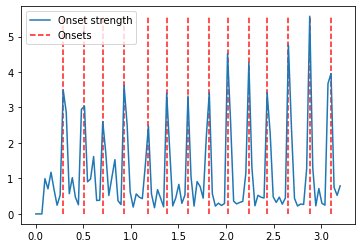

/home/haemin/anaconda3/envs/gct634_final/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


14


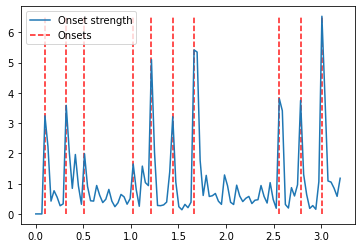

10


In [8]:
# Measure note density for every 100 frames
num_onset_threshold = 10
num_segments = len(audio) // segment_length
scaled_index = torch.full((num_segments,), -1)

scaled_audio = []
audio_segment = []
for i in range(num_segments):
    first_frame = i * segment_length               # 0~100, 100~200
    last_frame = first_frame + segment_length

    # Segment audio file
    segment = audio[first_frame:last_frame].astype(np.float32)
    audio_segment.append(segment)

    # Detect onset 
    onset_env = librosa.onset.onset_strength(segment, sr=SAMPLE_RATE)
    peaks = librosa.util.peak_pick(onset_env, peak_setting['pre_max'], peak_setting['post_max'], peak_setting['pre_avg'], peak_setting['post_avg'], peak_setting['delta'], peak_setting['wait'])
    times = librosa.times_like(onset_env, sr=SAMPLE_RATE)
    
    # Visualize onsets
    plt.plot(times, onset_env, label='Onset strength')
    plt.vlines(times[peaks], 0, onset_env.max(), color='r', alpha=0.9,
               linestyle='--', label='Onsets')
    plt.legend()
    plt.show()
    
    # Stretch segment based on number of detected onsets
    if len(peaks) == 0:
        num_onsets = 0      # no peaks detected
    else:
        num_onsets = len(times[peaks])
        print(num_onsets)

    if num_onsets >= num_onset_threshold:
        segment_scaled = tsm.wsola(segment, SCALE)
        scaled_audio.extend(segment_scaled)
        scaled_index[i] = first_frame // HOP_LENGTH
    else:
        scaled_audio.extend(segment)

In [9]:
ipd.Audio(scaled_audio, rate=SAMPLE_RATE)

In [ ]:
# ipd.Audio(audio_segment[0], rate=SAMPLE_RATE)

In [ ]:
# ipd.Audio(audio_segment[1], rate=SAMPLE_RATE)